Latent Variable Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import statsmodels.api as sm

rng = np.random.default_rng()

import pymc as pm
import arviz as az
# import pymc_experimental as pmx

In [2]:
x_min, x_max = -5, 5

def mu_true(x):
    return 1.0/(1.0+np.exp(-x))

def sigma_true(x):
    return 0.5+0.5/(1.0+x**2)

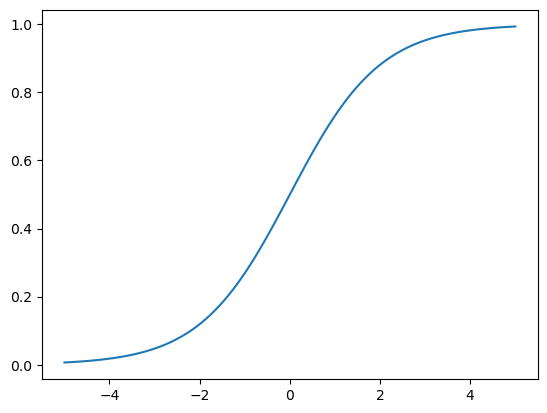

In [3]:
x_vals = np.linspace(x_min,x_max,100)
plt.plot(x_vals,mu_true(x_vals))

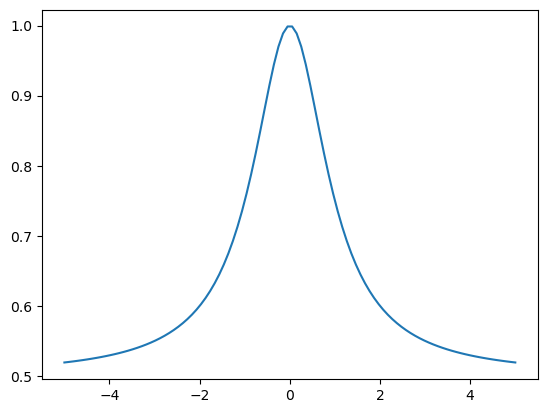

In [4]:
plt.plot(x_vals,sigma_true(x_vals))

In [5]:
x_sample = np.linspace(x_min,x_max,20)

In [6]:
n_samples = 10

y_obs = []

for x in x_sample:
    mu = mu_true(x)
    sigma = sigma_true(x)

    y = rng.normal(mu, sigma, size=n_samples)
    y_obs.append(y)

x_obs = np.tile(x_sample,(n_samples,1)).T
y_obs = np.array(y_obs)


y_obs_mean = y_obs.mean()
y_obs_std = y_obs.std()
z_obs = (y_obs - y_obs_mean)/y_obs_std
z_obs = y_obs

In [7]:
y_obs_mean, y_obs_std

(0.4477574236659077, 0.6726757009561871)

In [8]:
y_mean_est = y_obs.mean(axis=1)
y_std_est = y_obs.std(axis=1)
y_mean_se = y_std_est / np.sqrt(n_samples)
alpha = 0.05
z_alpha = sp.stats.t.ppf(1-alpha/2, n_samples-1)

<ErrorbarContainer object of 3 artists>

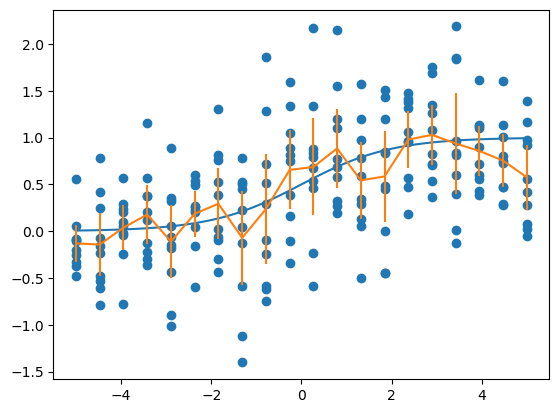

In [9]:
plt.scatter(x_obs,y_obs)
plt.plot(x_vals, mu_true(x_vals))
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se)

In [10]:
X = x_obs.ravel().reshape(-1,1)
Xpred = x_vals.reshape(-1,1)

In [11]:
coords = {
    "cov_params": ["mu","sigma"],
}

with pm.Model(coords=coords) as model:

    ls = pm.InverseGamma("ls", mu = 2.0, sigma = 2.0, dims = "cov_params")
    s2 = pm.Gamma("s2", alpha = 2, beta = 1, dims = "cov_params")


    # ls_loc = pm.InverseGamma("ls_loc", mu = 2.0, sigma = 2.0)
    # ls_scale = pm.InverseGamma("ls_scale", mu = 2.0, sigma = 2.0)
    # s2_loc = pm.Gamma("s2_loc", alpha = 2, beta = 1)
    # s2_scale = pm.Gamma("s2_scale", alpha = 2, beta = 1)
                                              
    # cov_loc = s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    # cov_scale = s2_scale**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_scale) + pm.gp.cov.WhiteNoise(sigma = 1e-6)

    # cov_loc = s2_loc**2 * pm.gp.cov.Exponential(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    # cov_scale = s2_scale**2 * pm.gp.cov.Exponential(input_dim = 1, ls = ls_scale) + pm.gp.cov.WhiteNoise(sigma = 1e-6)

    # cov_loc = s2["mu"]**2 * pm.gp.cov.Exponential(input_dim = 1, ls = ls["mu"]) 
    cov_loc = s2[0]**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls[0]) 
    cov_scale = s2[1]**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls[1])


    # cov_loc = s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    # cov_scale = s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)



    gp_loc = pm.gp.Latent(cov_func = cov_loc)
    gp_log_scale = pm.gp.Latent(cov_func = cov_scale)

    mu_mean = pm.Normal('mu_mean', mu = 0.5, sigma = 5.0)
    mu = pm.Deterministic("mu",  mu_mean +gp_loc.prior('mu_gp', X = X))

    log_sigma_mean = pm.Normal('log_sigma_mean', mu = 0.5, sigma = 5.0)
    log_sigma = pm.Deterministic("log_sigma",  log_sigma_mean + gp_log_scale.prior('log_sigma_gp', X = X))

    z = pm.Normal('z', mu = mu, sigma = pm.math.exp(log_sigma), observed = z_obs.ravel())
    # y = z * y_obs_std + y_obs_mean

    vi_approx = pm.fit()
    trace = vi_approx.sample(1000)
    # trace = pm.sample(1000, return_inferencedata = True)

    mu_pred = pm.Deterministic("mu_pred", mu_mean + gp_loc.conditional("mu_gp_pred", Xnew=Xpred,jitter=1e-3))
    log_sigma_pred = pm.Deterministic("log_sigma_pred", log_sigma_mean + gp_log_scale.conditional("log_sigma_gp_pred", Xnew=Xpred,jitter=1e-3))
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["mu_pred", "log_sigma_pred"])

Finished [100%]: Average Loss = 320.1
Sampling: [log_sigma_gp_pred, mu_gp_pred]


array([<AxesSubplot: title={'center': 'ls\nmu'}>,
       <AxesSubplot: title={'center': 'ls\nsigma'}>,
       <AxesSubplot: title={'center': 's2\nmu'}>,
       <AxesSubplot: title={'center': 's2\nsigma'}>], dtype=object)

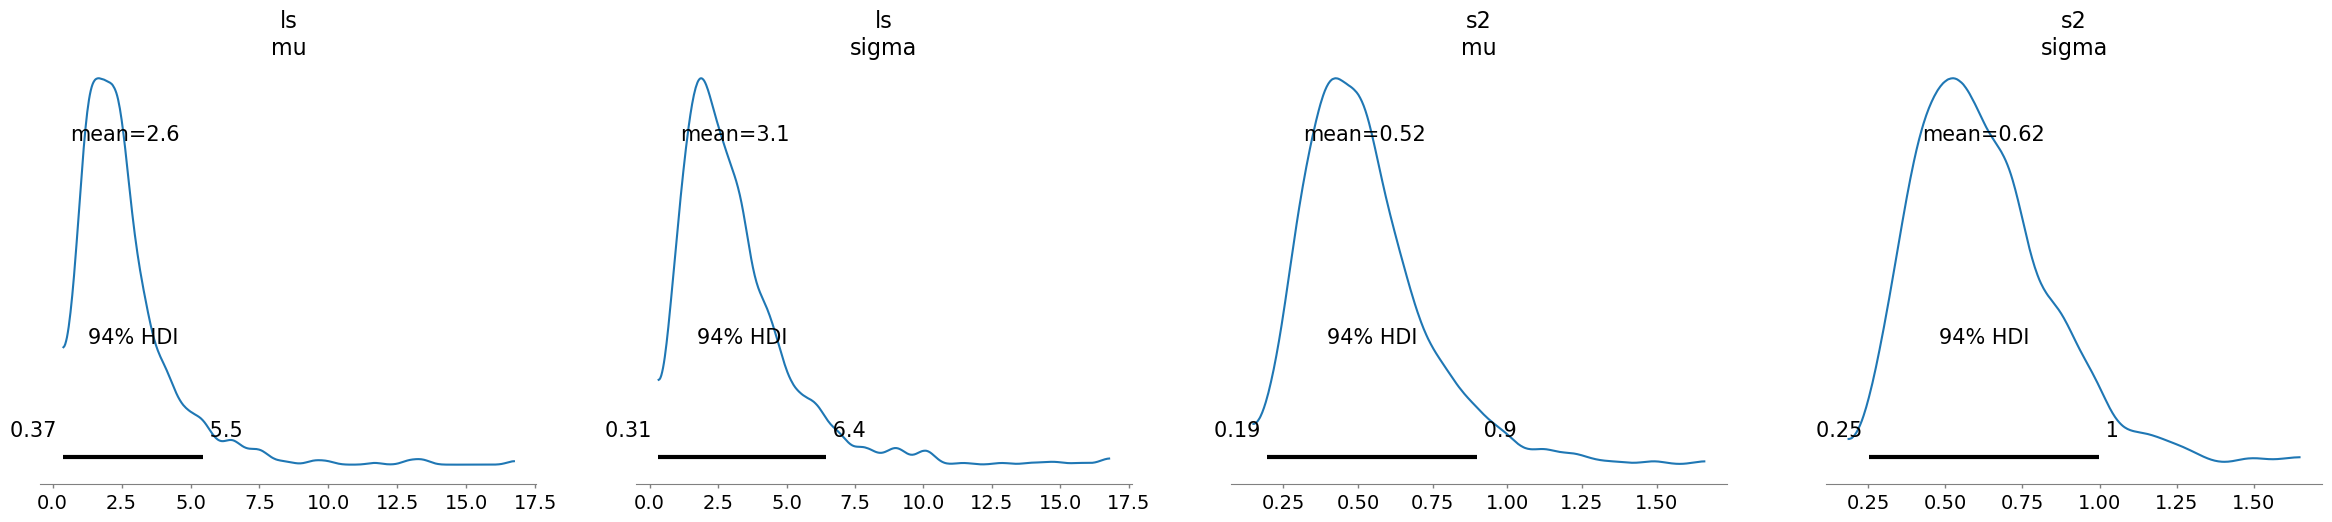

In [12]:
az.plot_posterior(trace, var_names = ["ls", "s2"])

array([<AxesSubplot: title={'center': 'mu_mean'}>,
       <AxesSubplot: title={'center': 'log_sigma_mean'}>], dtype=object)

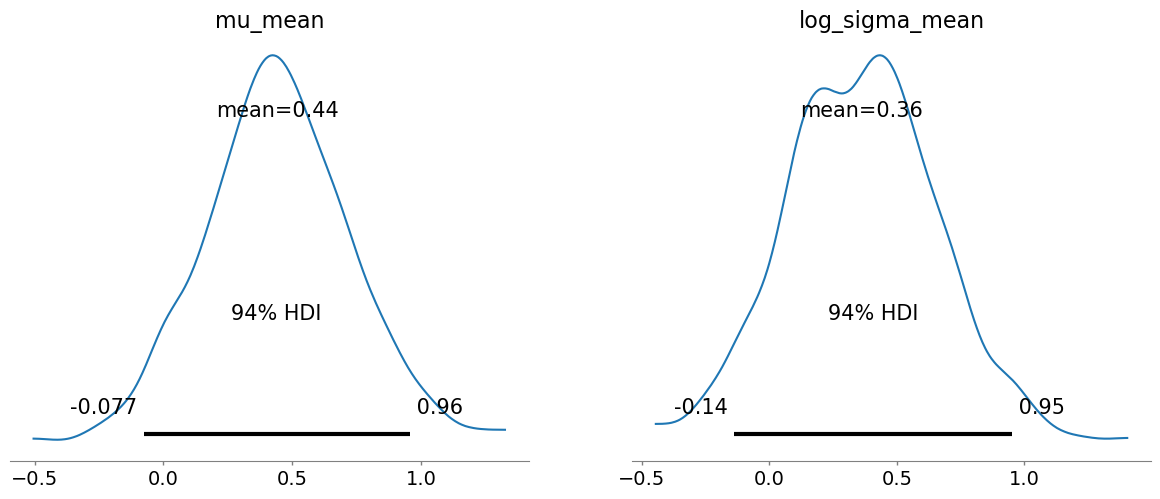

In [13]:
az.plot_posterior(trace, var_names = ["mu_mean","log_sigma_mean"])

In [14]:

# with model:
#     mu_pred = gp_loc.conditional("mu_pred2", Xnew=Xpred)
#     log_sigma_pred = gp_log_scale.conditional("log_sigma_pred2", Xnew=Xpred)
#     posterior_pred = pm.sample_posterior_predictive(trace, var_names=["mu_pred2", "log_sigma_pred2"])

In [15]:
# az.plot_trace(idata)

In [16]:
y_mean = y_obs.mean(axis=1)
y_sigma = np.std(y_obs,axis=1)

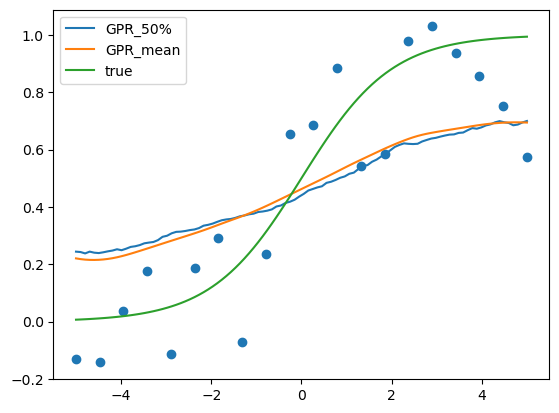

In [17]:
# plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].median(axis=(0,1))+y_obs_mean,label='GPR_50%')
# plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].median(axis=(0,1)),label='GPR_50%')
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1)),label='GPR_mean')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.scatter(x_sample,y_mean)
plt.legend()

In [18]:
alpha = 0.05
# latent_mu_median = posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1))+y_obs_mean
# latent_mu_L = np.quantile(posterior_pred.posterior_predictive['mu_pred'],alpha/2, axis=(0,1))+y_obs_mean
# latent_mu_U = np.quantile(posterior_pred.posterior_predictive['mu_pred'], 1-alpha/2, axis=(0,1))+y_obs_mean

latent_mu_median = posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1))
latent_mu_L = np.quantile(posterior_pred.posterior_predictive['mu_pred'],alpha/2, axis=(0,1))
latent_mu_U = np.quantile(posterior_pred.posterior_predictive['mu_pred'], 1-alpha/2, axis=(0,1))

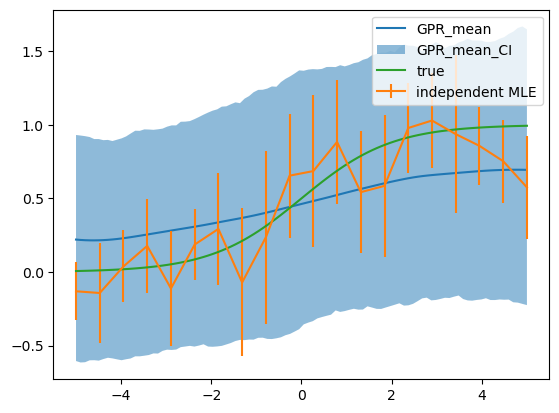

In [19]:
# plt.scatter(x_obs,y_obs)

# plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred'].mean(axis=(0,1)),label='GPR_mean')
plt.fill_between(x_vals,latent_mu_L,latent_mu_U,alpha=0.5,label='GPR_mean_CI')
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se,label='independent MLE')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.legend()

Smoother results with more accuracy (except for the edges)


In [20]:
# sigma_pred = np.exp(posterior_pred.posterior_predictive['log_sigma_pred'])*y_obs_std
sigma_pred = np.exp(posterior_pred.posterior_predictive['log_sigma_pred'])

latent_sigma_median = np.quantile(sigma_pred,0.5, axis=(0,1))
latent_sigma_L = np.quantile(sigma_pred, alpha/2, axis=(0,1))
latent_sigma_U = np.quantile(sigma_pred, 1-alpha/2, axis=(0,1))

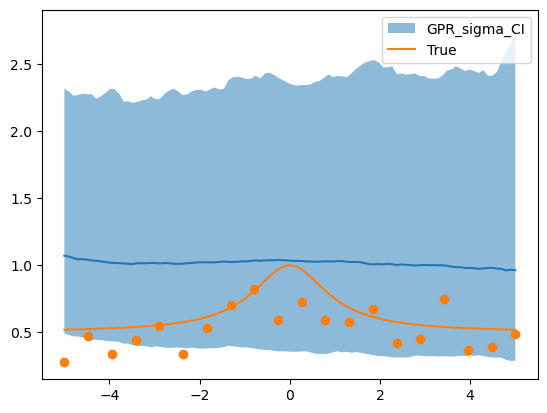

In [21]:



plt.plot(x_vals,latent_sigma_median)
plt.fill_between(x_vals,latent_sigma_L,latent_sigma_U,alpha=0.5,label='GPR_sigma_CI')

plt.scatter(x_sample,y_sigma)
plt.plot(x_vals, sigma_true(x_vals),label='True')
plt.legend()

In [22]:
from pymc.gp.util import plot_gp_dist

In [23]:
# add mean to GPR
"""
* Add group mean before GPR
* mu, sigma, xi all independent GP (with different length scales and variance)
* sigma = exp(log_sigma), log_sigma ~ normal
"""

'\n* Add group mean before GPR\n* mu, sigma, xi all independent GP (with different length scales and variance)\n* sigma = exp(log_sigma), log_sigma ~ normal\n'